In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import h5py
import matplotlib.pyplot as plt
import hdc
import numpy as np
from sklearn import svm
from itertools import combinations

%matplotlib notebook

In [2]:
dataFile = '/Users/andy/Research/py_hdc_cont/emg_mat/armPosition/sub1exp0.mat'
# file is saved in hdf5 format
file = h5py.File(dataFile,'r')
experimentData = file['experimentData']
keys = list(experimentData.keys())

print('Available keys include:')
for k in keys:
    print('  ' + k)
    
numTrials, numPositions, numGestures = experimentData[keys[0]].shape
D = file[experimentData[keys[4]][0,0,0]].shape[1]

Available keys include:
  accMeanFeat
  accRaw
  accStdFeat
  emgFeat
  emgHV
  emgRaw
  expGestLabel
  expPosLabel


In [3]:
numTrainPositions = 3
trainCombinations = list(combinations(np.arange(numPositions),numTrainPositions))
numCombinations = len(trainCombinations)

In [4]:
numIters = 1

meanHDAcc = np.zeros((numCombinations,numPositions))
meanSVMAcc = np.zeros((numCombinations,numPositions))

for apComb in range(numCombinations):
    for apTest in range(numPositions):
        hdAcc = []
        svmAcc = []
        for n in range(numIters):
            # set up new associative memory
            AM = []
            AM = hdc.Memory(D)
            # train/test split with single trial for training, remaining trials for testing
            trainTrials = np.random.randint(numTrials,size=numGestures)
            # train AM and build training array for SVM
            Xtrain = np.empty((0,320))
            ytrain = np.empty(0)
            for apTrain in trainCombinations[apComb]:
                for g in range(numGestures):
                    for t in range(numTrials):
                        if t == trainTrials[g]:
                            expLabel = file[experimentData['expGestLabel'][t,apTrain,g]][0,:]
                            ng = file[experimentData['emgHV'][t,apTrain,g]][expLabel>0,:]
#                             AM.train(ng,vClass=g,vClust=0)
#                             AM.train(ng,vClass=g,vClust=apTrain)
                            AM.train_sub_cluster(ng,vClass=g)
                            AM.prune(min=5)

                            # gather features for SVM (or other model)
                            feat = file[experimentData['emgFeat'][t,apTrain,g]][:,expLabel>0].T
                            numEx, numCh = feat.shape
                            ngramLen = 5
                            x = np.zeros((numEx-ngramLen+1,numCh*ngramLen))
                            for i in range(ngramLen):
                                x[:,np.arange(numCh)+i*numCh] = feat[np.arange(numEx-ngramLen+1)+i,:]*6400
                            Xtrain = np.concatenate((Xtrain,x))
                            ytrain = np.concatenate((ytrain,g*np.ones(numEx-ngramLen+1)))
            
            # train SVM (or other model)
            clf = svm.SVC(decision_function_shape='ovo',kernel='linear',C=1)
            clf.fit(Xtrain,ytrain)
            
            # test AM
            for g in range(numGestures):
                for t in range(numTrials):
                    if t != trainTrials[g]:
                        expLabel = file[experimentData['expGestLabel'][t,apTest,g]][0,:]
                        ng = file[experimentData['emgHV'][t,apTest,g]][expLabel>0,:]
                        label,sim = AM.match(np.asarray(ng),bipolar=True)
                        hdAcc.append(np.sum(np.asarray(label) == g)/len(label))
                        
                        feat = file[experimentData['emgFeat'][t,apTest,g]][:,expLabel>0].T
                        numEx, numCh = feat.shape
                        ngramLen = 5
                        x = np.zeros((numEx-ngramLen+1,numCh*ngramLen))
                        for i in range(ngramLen):
                            x[:,np.arange(numCh)+i*numCh] = feat[np.arange(numEx-ngramLen+1)+i,:]*6400
                        
                        yhat = clf.predict(x)
                        svmAcc.append(np.sum(yhat == g)/len(yhat))
        
        meanHDAcc[apComb,apTest] = np.mean(hdAcc)
        meanSVMAcc[apComb,apTest] = np.mean(svmAcc)
        
        

In [5]:
def plot_arm_position(acc):
    h,w = acc.shape
    data = acc*100

    # Limits for the extent
    x_start = 0
    x_end = w
    y_start = 0
    y_end = h

    extent = [x_start, x_end, y_start, y_end]

    # The normal figure
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    im = ax.imshow(data, extent=extent, interpolation='None', cmap='viridis', vmin=0, vmax=100)

    # Add the text
    jump_x = (x_end - x_start) / (2.0 * w)
    jump_y = (y_end - y_start) / (2.0 * h)
    x_positions = np.linspace(start=x_start, stop=x_end, num=w, endpoint=False)
    y_positions = np.flip(np.linspace(start=y_start, stop=y_end, num=h, endpoint=False))

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label = data[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            ax.text(text_x, text_y, '%.4f' % (label), color='black', ha='center', va='center')

    fig.colorbar(im)


<IPython.core.display.Javascript object>


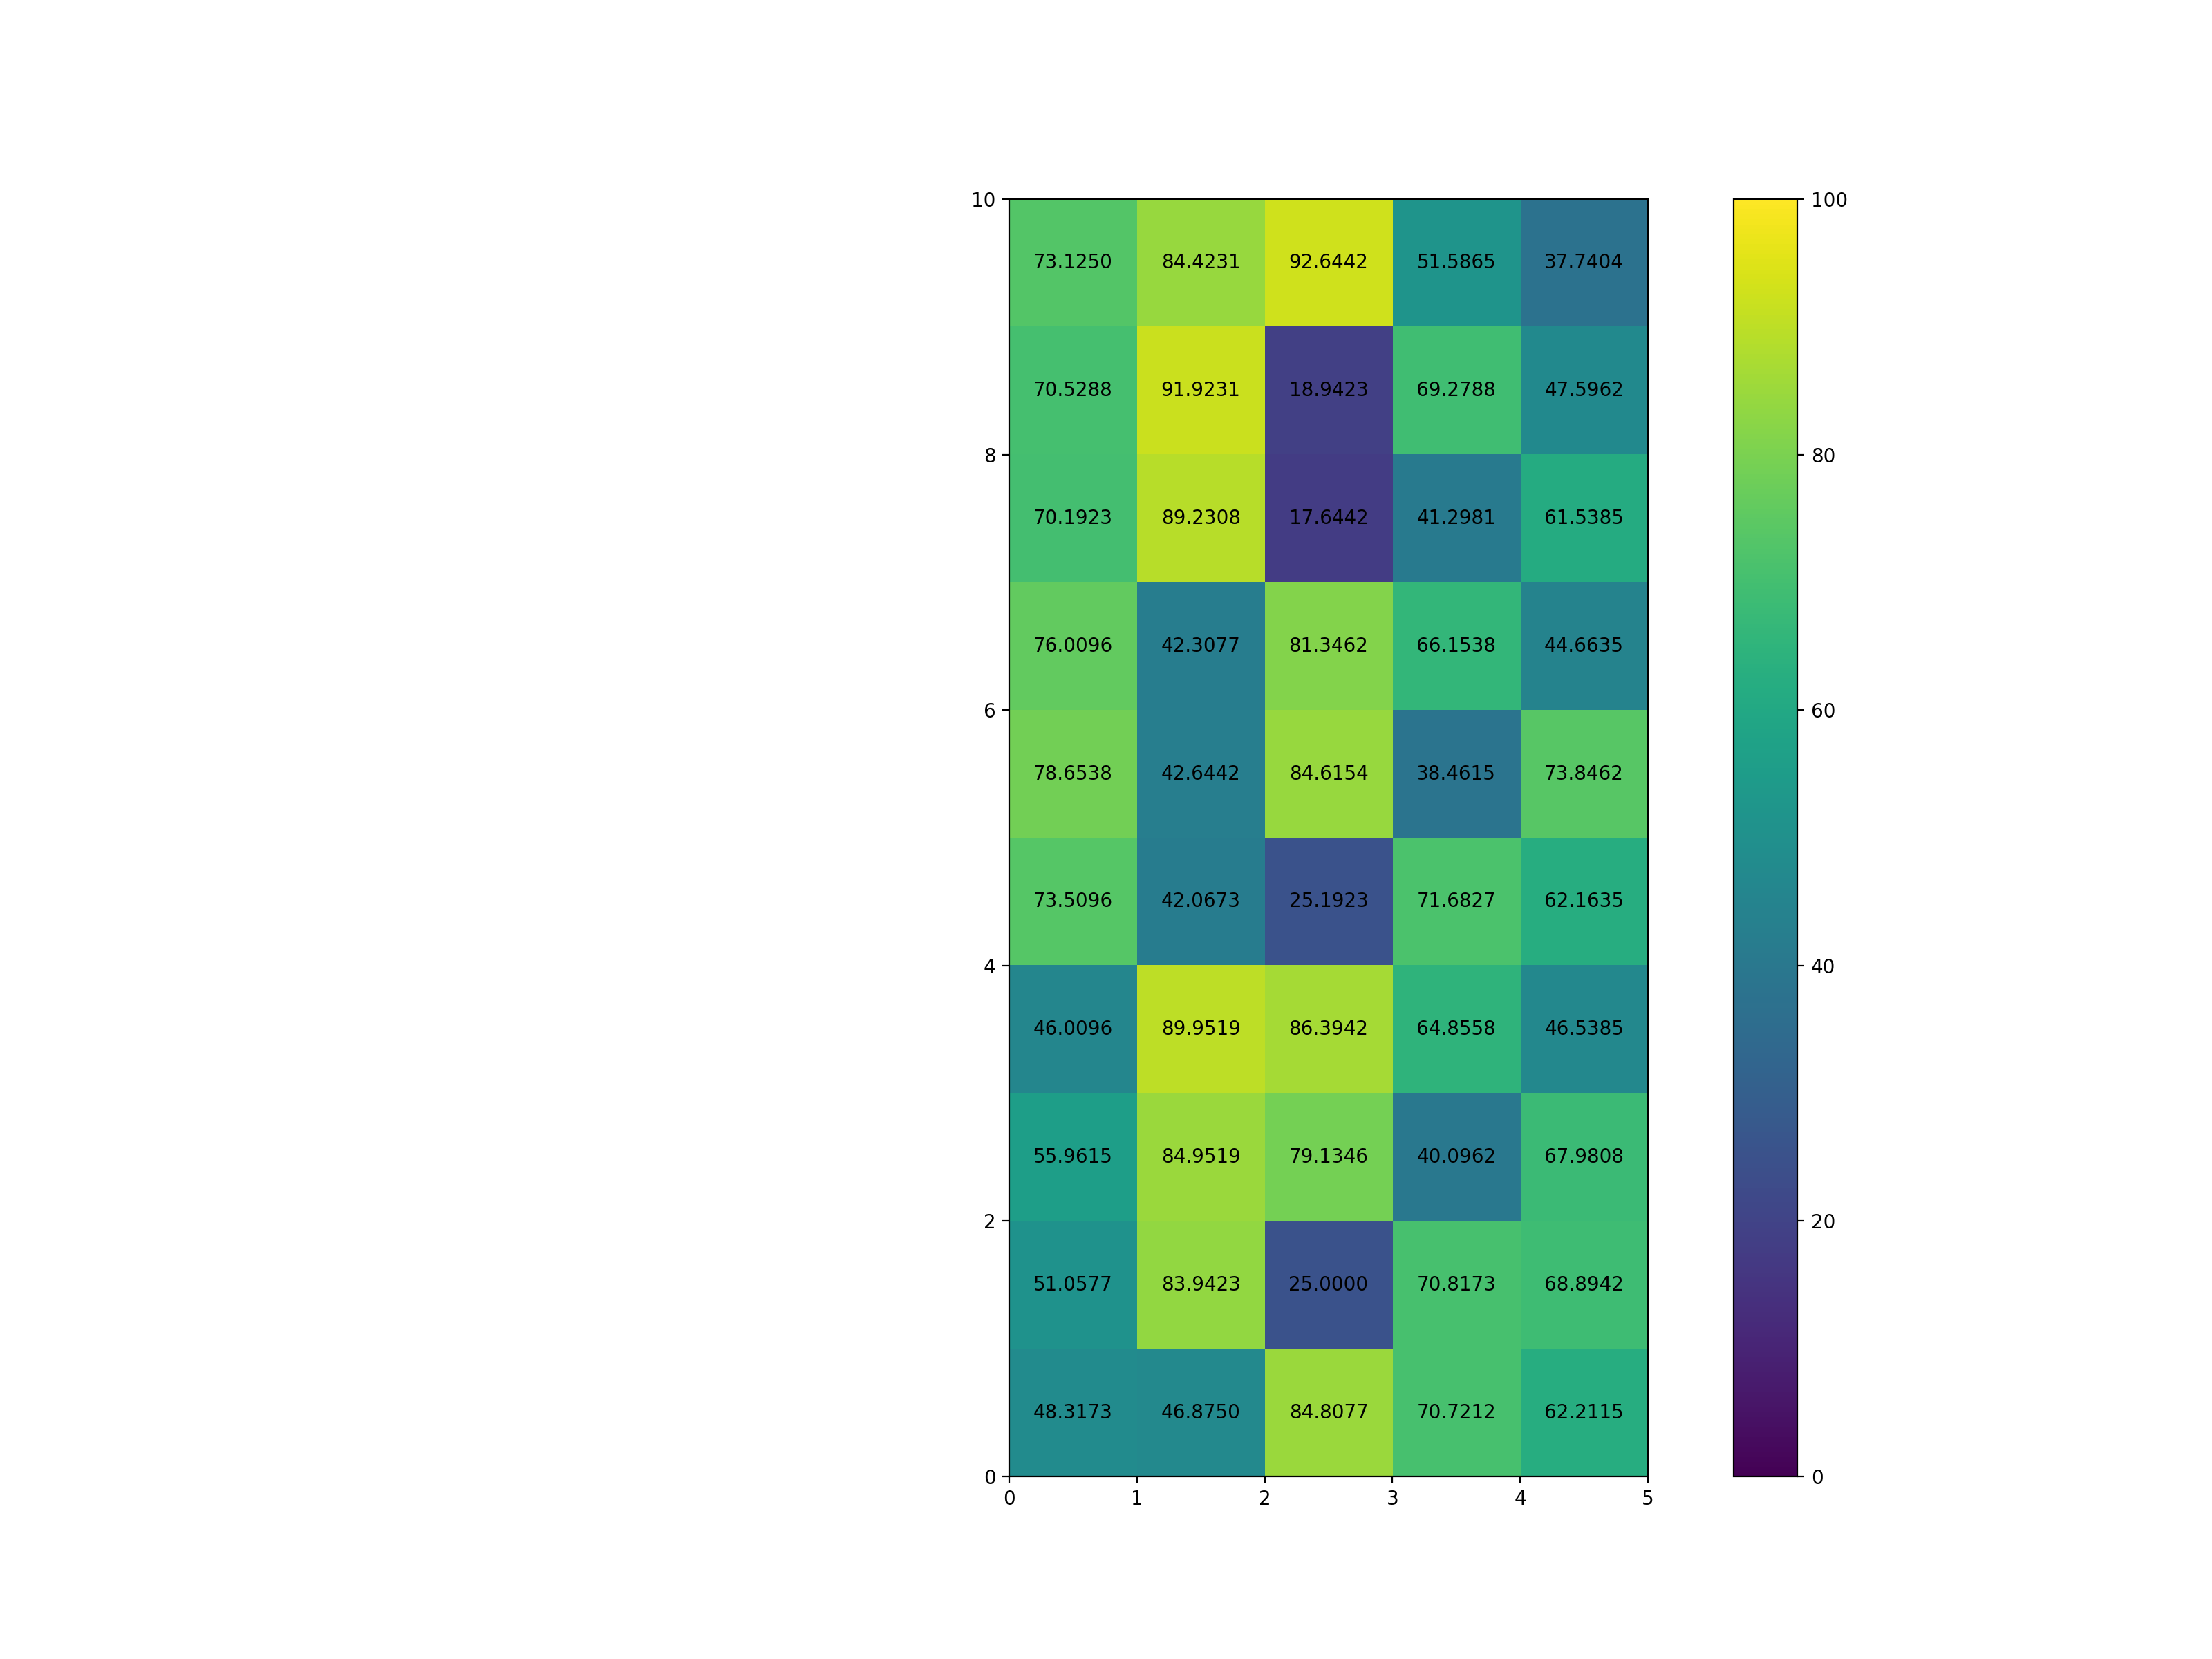

In [6]:
plot_arm_position(meanHDAcc)

<IPython.core.display.Javascript object>


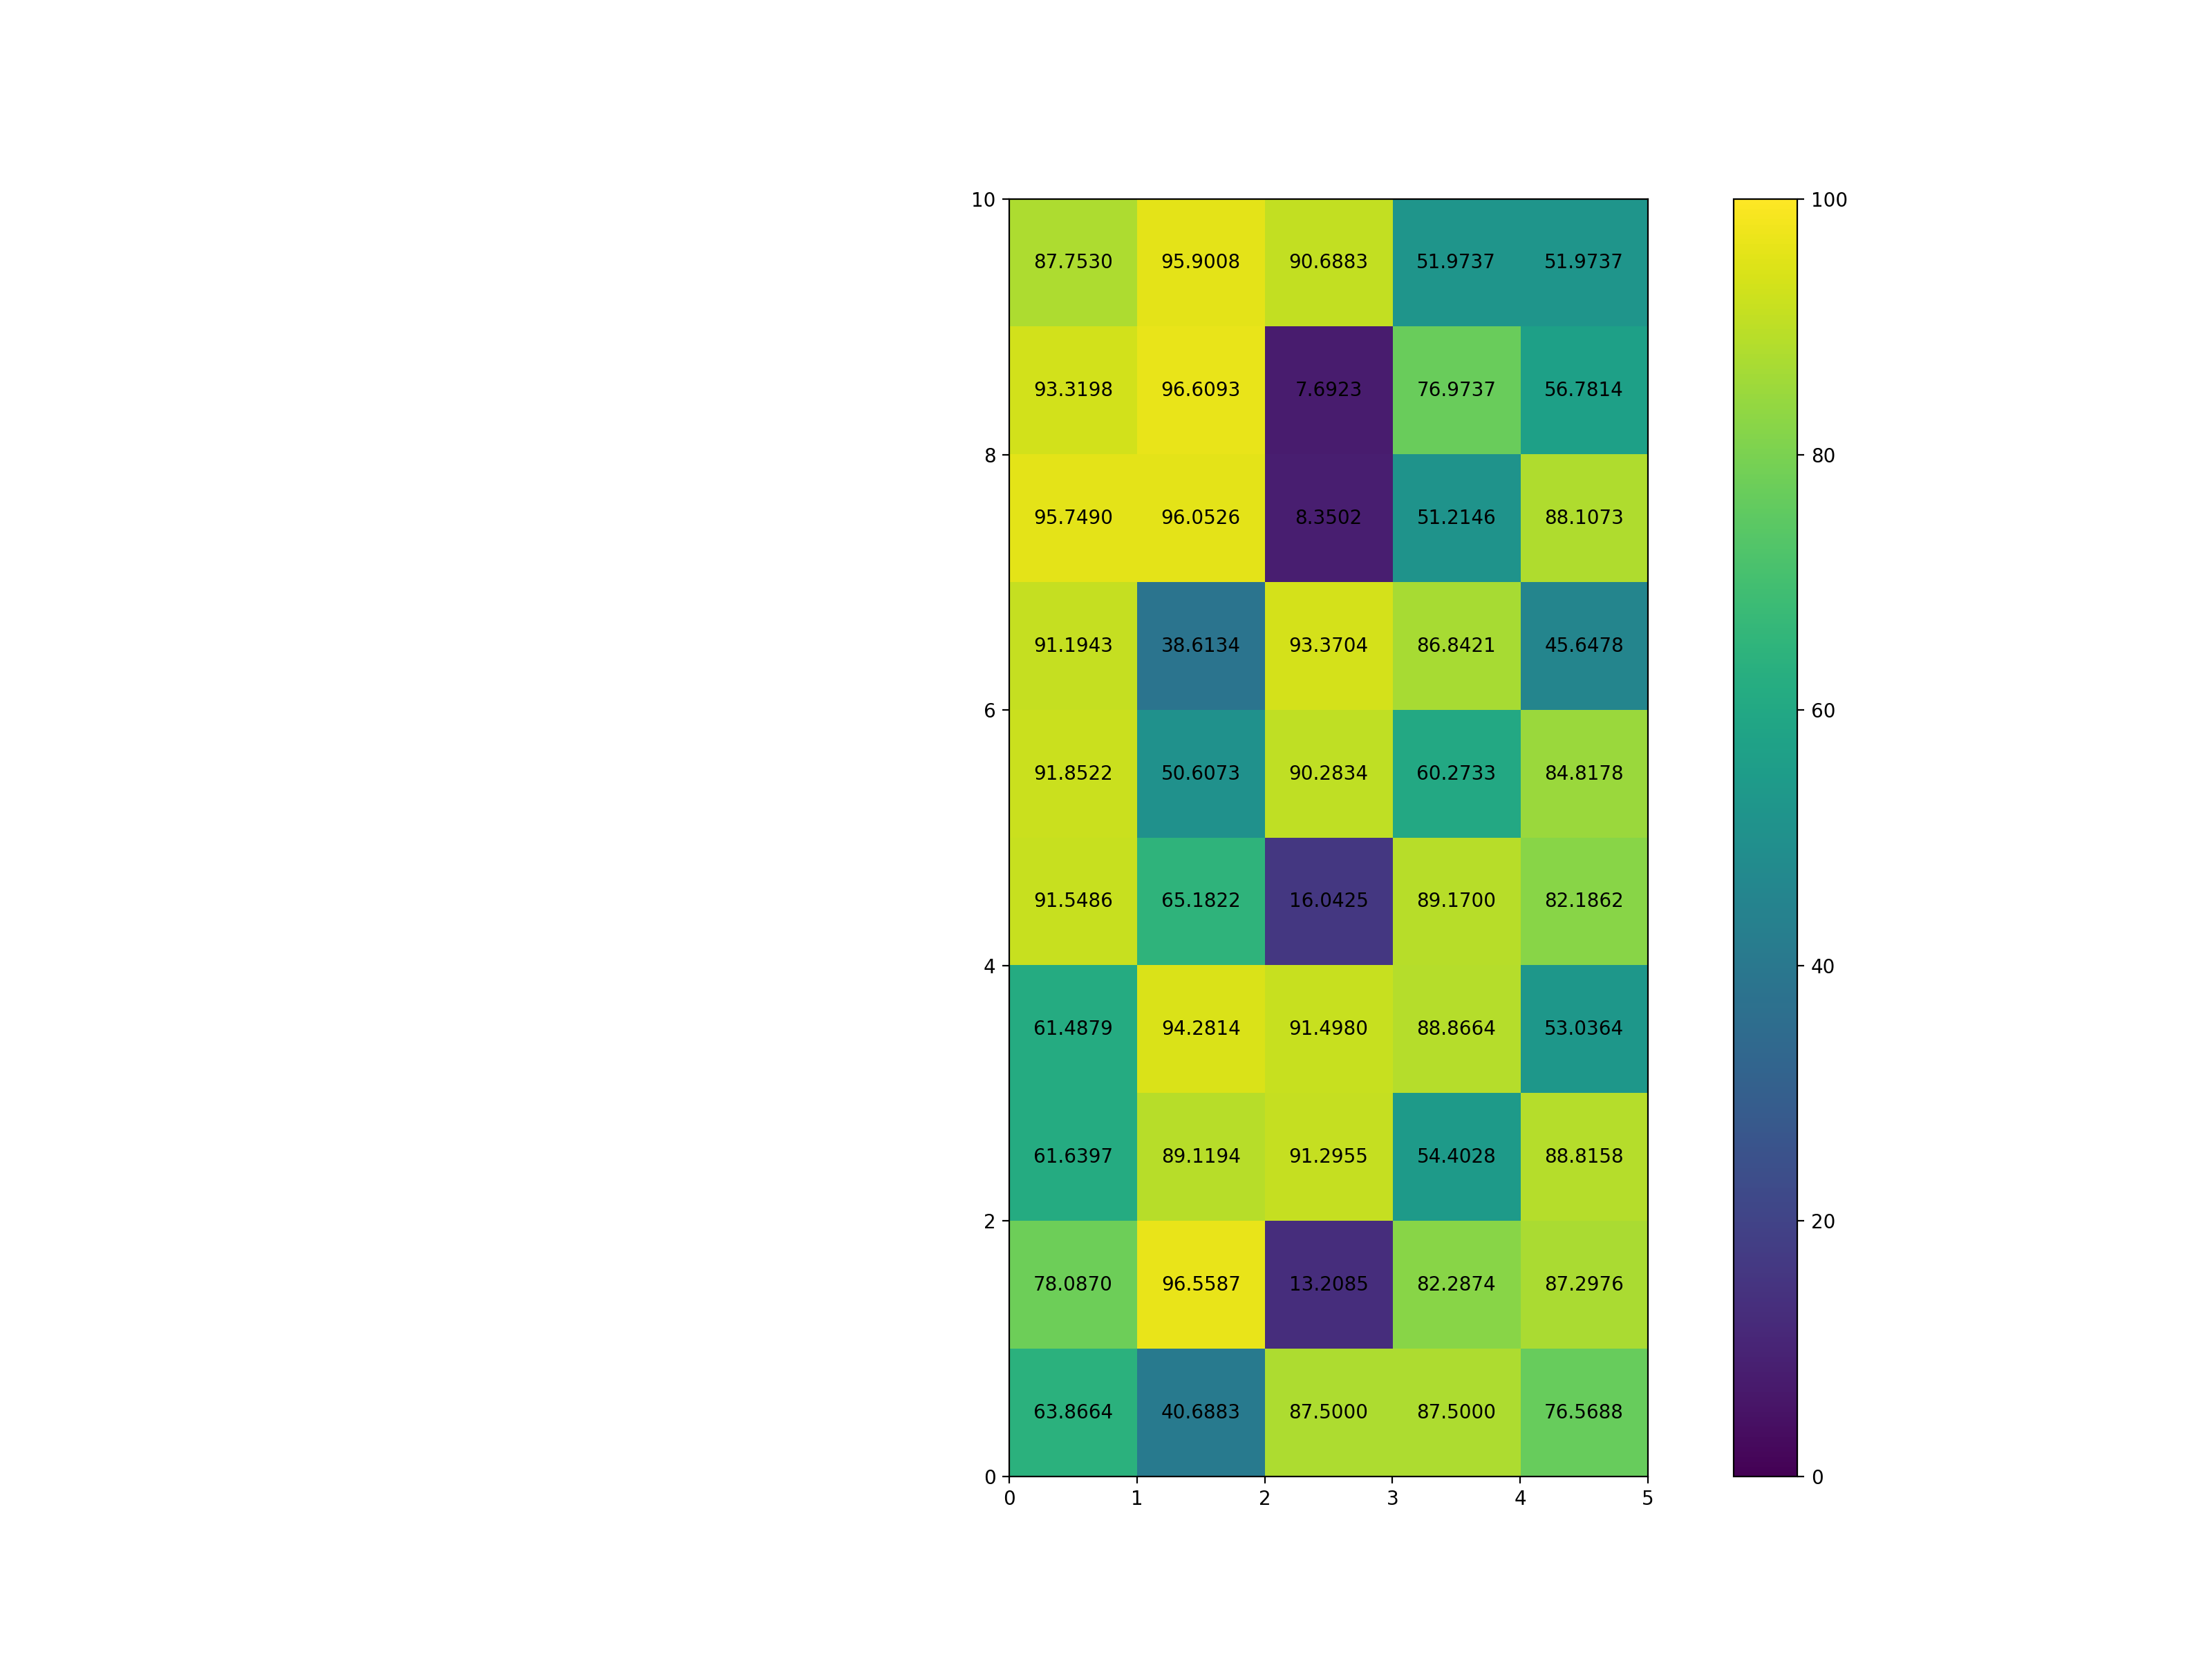

In [7]:
plot_arm_position(meanSVMAcc)

In [8]:
AM

Class 0, Cluster 0: [ -8.   6.   6. ... -44.   6.   6.]
Class 1, Cluster 0: [ 110. -162. -162. ...   24.   26.   24.]
Class 2, Cluster 0: [ 80.  22.  18. ...   2. -32. -28.]
Class 3, Cluster 0: [-2. 10.  8. ...  2.  4.  2.]
Class 4, Cluster 0: [  57. -167. -167. ...   63.   67.   63.]
Class 5, Cluster 0: [-24. -42. -42. ...  14.  16.  14.]
Class 6, Cluster 0: [-52. -58. -56. ...  78.  56.  54.]
Class 7, Cluster 0: [-38. -54. -56. ...  60.  34.  34.]
Class 8, Cluster 0: [ 20. -66. -66. ... -30. -22. -24.]
Class 9, Cluster 0: [ 22. -54. -54. ... -28.  -8.  -6.]
Class 10, Cluster 0: [-26. -42. -42. ...  44.  24.  24.]
Class 11, Cluster 0: [ 56.  76.  76. ...  50. -48. -48.]
Class 12, Cluster 0: [-13. -25. -23. ...  13.  11.  11.]
Class 0, Cluster 3: [  6.   6.  -4. ... -14.   0.   6.]
Class 0, Cluster 53: [-5.  3.  3. ...  5. -3. -1.]
Class 1, Cluster 1: [ 1. -1.  1. ...  1.  1.  1.]
Class 1, Cluster 2: [-1. -1. -1. ... -1.  1.  1.]
Class 1, Cluster 6: [-2. -2. -4. ... -4. -4. -2.]
Class 